In [319]:
%matplotlib inline

from joblib import load
import itertools
import json
import os
import random

from hyperopt import fmin, hp, tpe, Trials, STATUS_OK
from hyperopt.pyll.base import scope
from sklearn.metrics import make_scorer
from sklearn.model_selection import StratifiedKFold
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# scikit-learn
import sklearn
from sklearn.ensemble import ExtraTreesClassifier, GradientBoostingClassifier, RandomForestClassifier
from sklearn.metrics import accuracy_score, average_precision_score, confusion_matrix, \
    f1_score, fbeta_score, log_loss, make_scorer, precision_recall_fscore_support, \
    precision_score, precision_recall_curve, recall_score
from sklearn.model_selection import cross_validate, train_test_split, StratifiedKFold, StratifiedShuffleSplit
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.svm import SVC

# Models
from xgboost import XGBClassifier

# NLP
import gc
import re
import string
import operator
from collections import defaultdict


# Configure options
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

random_state = 11

random.seed(random_state)
np.random.seed(random_state)

In [320]:
from data_exploration.data_visualization import histogram_grid, plot_missing_variable_count, \
plot_variable_dists_by_class_and_dataset

from data_preparation.data_preparation import check_missing_values, add_dummies, add_decomposed_date_variables, \
impute_missing, find_mislabeled

In [321]:
root = '/home/jovyan/work/Documents/relax_challenge'
os.listdir(root)

['.bash',
 'takehome_users.csv',
 'relax_data_science_challenge.pdf',
 'data_preparation',
 'README.md',
 'predicting_user_adoption.ipynb',
 '.ipynb_checkpoints',
 'takehome_user_engagement.csv',
 'conda_jupyter_notebook',
 'data_exploration',
 '.idea']

# Data preparation

In [322]:
users = pd.read_csv(root + "/takehome_users.csv", encoding="ISO-8859-1")
ueng = pd.read_csv(root + "/takehome_user_engagement.csv", encoding="ISO-8859-1")


In [323]:
users

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0
...,...,...,...,...,...,...,...,...,...,...
11995,11996,2013-09-06 06:14:15,Meier Sophia,SophiaMeier@gustr.com,ORG_INVITE,1.378448e+09,0,0,89,8263.0
11996,11997,2013-01-10 18:28:37,Fisher Amelie,AmelieFisher@gmail.com,SIGNUP_GOOGLE_AUTH,1.358275e+09,0,0,200,NaN
11997,11998,2014-04-27 12:45:16,Haynes Jake,JakeHaynes@cuvox.de,GUEST_INVITE,1.398603e+09,1,1,83,8074.0
11998,11999,2012-05-31 11:55:59,Faber Annett,mhaerzxp@iuxiw.com,PERSONAL_PROJECTS,1.338638e+09,0,0,6,NaN


In [324]:
ueng

,time_stamp,user_id,visited
0,2014-04-22 03:53:30,1,1
1,2013-11-15 03:45:04,2,1
2,2013-11-29 03:45:04,2,1
3,2013-12-09 03:45:04,2,1
4,2013-12-25 03:45:04,2,1
...,...,...,...
207912,2013-09-06 06:14:15,11996,1
207913,2013-01-15 18:28:37,11997,1
207914,2014-04-27 12:45:16,11998,1
207915,2012-06-02 11:55:59,11999,1


In [325]:
def check_duplicates(df):
    for column in df.columns:
        duplicated = df[df[column].duplicated()]
        if len(duplicated) > 0:
            print(column, len(duplicated), len(duplicated) / len(df) * 100)

check_duplicates(users)

creation_time 4 0.03333333333333333
name 645 5.375
email 20 0.16666666666666669
creation_source 11995 99.95833333333334
last_session_creation_time 3178 26.48333333333333
opted_in_to_mailing_list 11998 99.98333333333333
enabled_for_marketing_drip 11998 99.98333333333333
org_id 11583 96.525
invited_by_user_id 9435 78.625


In [326]:
users[users['email'].duplicated()].sort_values(by='email')

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
3822,3823,2012-11-22 05:51:29,Lane Alfie,AlfieLane@yahoo.com,ORG_INVITE,1.353650e+09,0,0,169,9498.0
9040,9041,2013-01-03 00:53:47,Bach Amanda,AmandaABach@gmail.com,ORG_INVITE,NaN,0,0,377,6208.0
5081,5082,2013-06-25 19:31:11,Tye Jacob,JacobTye@gmail.com,SIGNUP_GOOGLE_AUTH,1.372361e+09,0,0,298,NaN
3605,3606,2013-05-10 08:31:59,Sankt Janina,JaninaSankt@gmail.com,GUEST_INVITE,1.369816e+09,0,0,84,8356.0
11244,11245,2014-01-17 18:05:15,Neudorf Kerstin,KerstinNeudorf@gmail.com,SIGNUP,1.389982e+09,1,1,68,NaN
4955,4956,2013-01-28 23:21:34,Mueller Klaus,KlausMueller@gustr.com,GUEST_INVITE,1.359415e+09,1,0,19,3225.0
6432,6433,2014-05-09 10:31:42,Kappel Kristin,KristinKappel@yahoo.com,SIGNUP,1.399804e+09,1,1,202,NaN
6536,6537,2014-05-09 00:19:37,Bertelsen Lærke,LaerkeMBertelsen@gmail.com,PERSONAL_PROJECTS,NaN,1,1,127,NaN
7257,7258,2013-05-14 20:04:00,Nørgaard Lasse,LasseLNrgaard@gmail.com,ORG_INVITE,NaN,0,0,35,1904.0
11905,11906,2014-04-14 21:24:59,Duerr Leonie,LeonieDuerr@gmail.com,ORG_INVITE,1.401917e+09,0,0,200,190.0


In [327]:
# Looks like these users signed up twice
users[users['email'] == 'AlfieLane@yahoo.com']

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
1603,1604,2014-02-03 04:48:08,Lane Alfie,AlfieLane@yahoo.com,ORG_INVITE,1.391662e+09,0,0,0,4128.0
3822,3823,2012-11-22 05:51:29,Lane Alfie,AlfieLane@yahoo.com,ORG_INVITE,1.353650e+09,0,0,169,9498.0


In [328]:
# Drop duplicated users for now since there are only 20 of them
users_processed = users[~users['email'].duplicated()]
print(len(users) - len(users_processed))

20


In [329]:
# Lots of missing values for last session. 
check_missing_values(users_processed)
# impute_missing 
# find_mislabeled

last_session_creation_time 3172 26.47746243739566
invited_by_user_id 5571 46.502504173622704


In [330]:
last_login = ueng.sort_values(by='time_stamp').groupby('user_id').agg({
    'time_stamp': 'last',
    'visited': 'sum'
})

In [331]:
# Looks like some users signed up but never logged in
users_with_login = users_processed[~users_processed['last_session_creation_time'].isnull()][['object_id', 'last_session_creation_time']]
print(len(users_with_login), len(last_login))
print(len(users_with_login['object_id'].isin(last_login.index)))
print(len(last_login.index.isin(users_with_login['object_id'])))

8808 8823
8808
8823


In [332]:
# The last login values from users and ueng match up. 
users_last_login_unix = users_processed[['object_id', 'last_session_creation_time']].set_index('object_id').rename_axis('user_id')
last_login['last_session_creation_time'] = pd.to_datetime(last_login['time_stamp']).astype(np.int64) / 1e9

# Create feature from the engagement data
last_login = last_login.rename({'visited': 'num_logins'}, axis=1)

merged = last_login.merge(users_last_login_unix, on='user_id', suffixes=('_user_eng', '_user'))
merged[merged['last_session_creation_time_user_eng'] - merged['last_session_creation_time_user'] != 0]

,time_stamp,num_logins,last_session_creation_time_user_eng,last_session_creation_time_user
user_id,,,,


In [333]:
ueng['dt'] = pd.to_datetime(ueng['time_stamp'])
ueng = ueng.sort_values(by=['user_id', 'dt'])
# Create is_adopted feature
is_adopted_data = []

def is_adopted(timestamps):
    if len(timestamps) < 3:
        return False
    
    for idx in range(len(timestamps) - 2):
        first_day = timestamps.iloc[idx]
        last_day = timestamps.iloc[idx + 2]
        
        if (last_day - first_day).days > 7:
            continue
        
        days = set([ts.day for ts in timestamps.iloc[idx:idx + 3]])
        if len(days) == 3:
            return True
    
    return False

for user_id in ueng['user_id'].unique():
    timestamps = ueng[ueng['user_id'] == user_id]['dt']
    is_user_adopted = is_adopted(timestamps)
    is_adopted_data.append({'user_id': user_id, 'is_adopted': is_user_adopted})

is_adopted_df = pd.DataFrame(is_adopted_data).set_index('user_id').astype(int) 

users_processed = users_processed.set_index('object_id').rename_axis('user_id').drop(['last_session_creation_time'], axis=1)

In [356]:
all_user_data = is_adopted_df.join([users_processed, last_login[['num_logins']]])

print('drop', len(all_user_data) - len(all_user_data[~all_user_data['creation_time'].isnull()]), 'rows')
all_user_data = all_user_data[~all_user_data['creation_time'].isnull()]
all_user_data.loc[:, 'creation_time'] = pd.to_datetime(all_user_data['creation_time'])

# This variable is a timestamp so it needs to be analyzed differently compared to the numeric and categorical 
# variables
creation_day = all_user_data['creation_time'].dt.round('D')

date_features = ['creation_time']
all_user_data, date_columns = add_decomposed_date_variables(all_user_data, date_features)

all_user_data.loc[:, 'creation_source'] = all_user_data['creation_source'].str.lower()

categorical_features = ['creation_source']
all_user_data, categories = add_dummies(all_user_data, categorical_features)

all_user_data = all_user_data.drop(['creation_time', 'name', 'email', 'creation_source'], axis=1)

drop 15 rows
encoder categories for creation_source [array(['guest_invite', 'org_invite', 'personal_projects', 'signup',
       'signup_google_auth'], dtype=object)]


# Data exploration

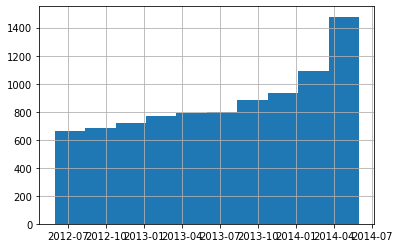

In [358]:
creation_day.hist()

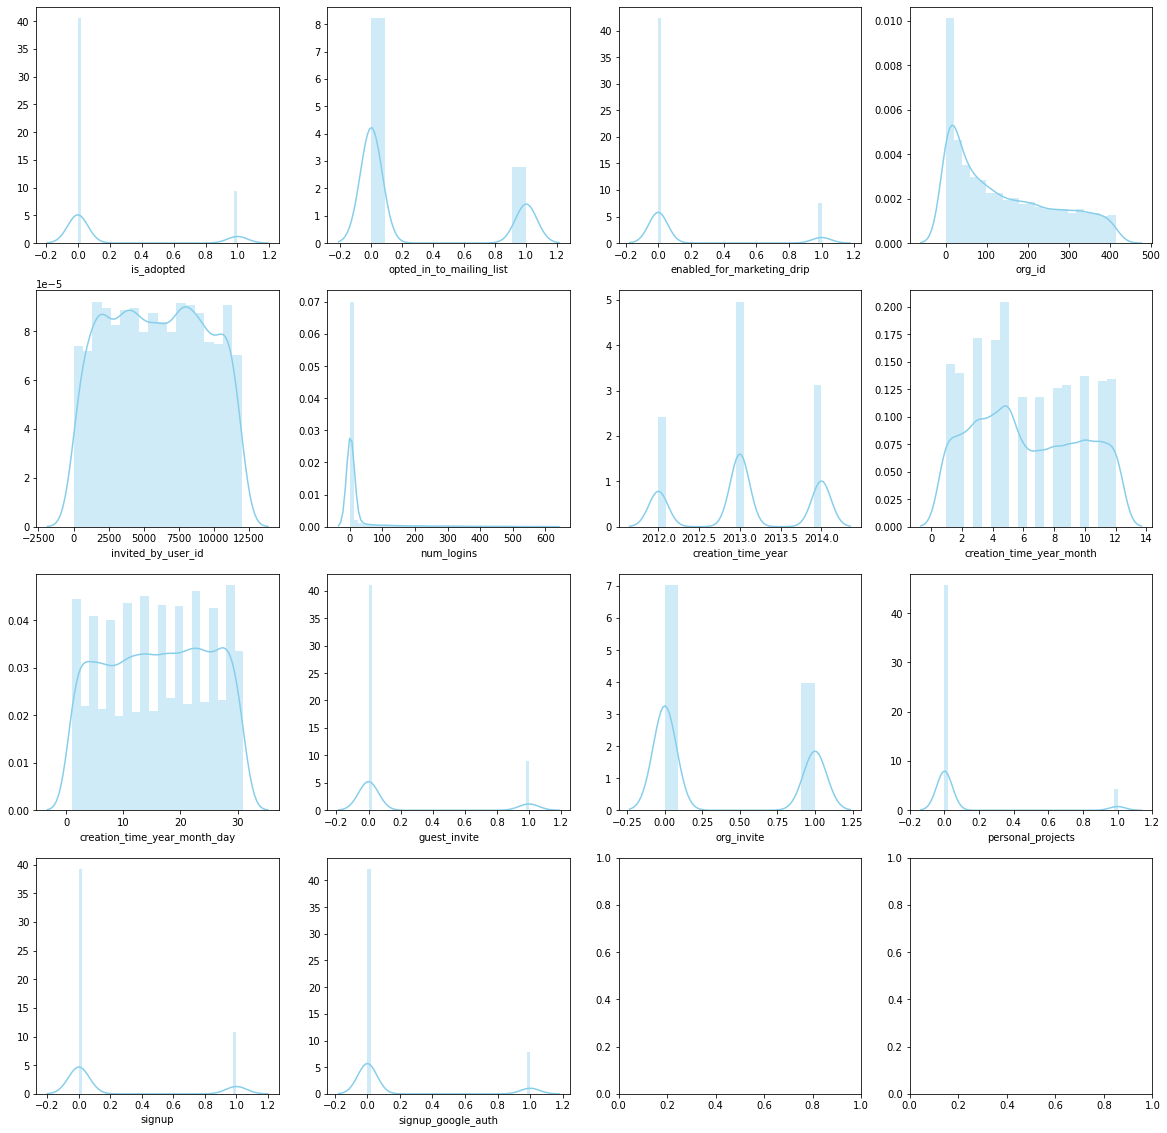

In [359]:
histogram_grid(all_user_data, all_user_data.columns)

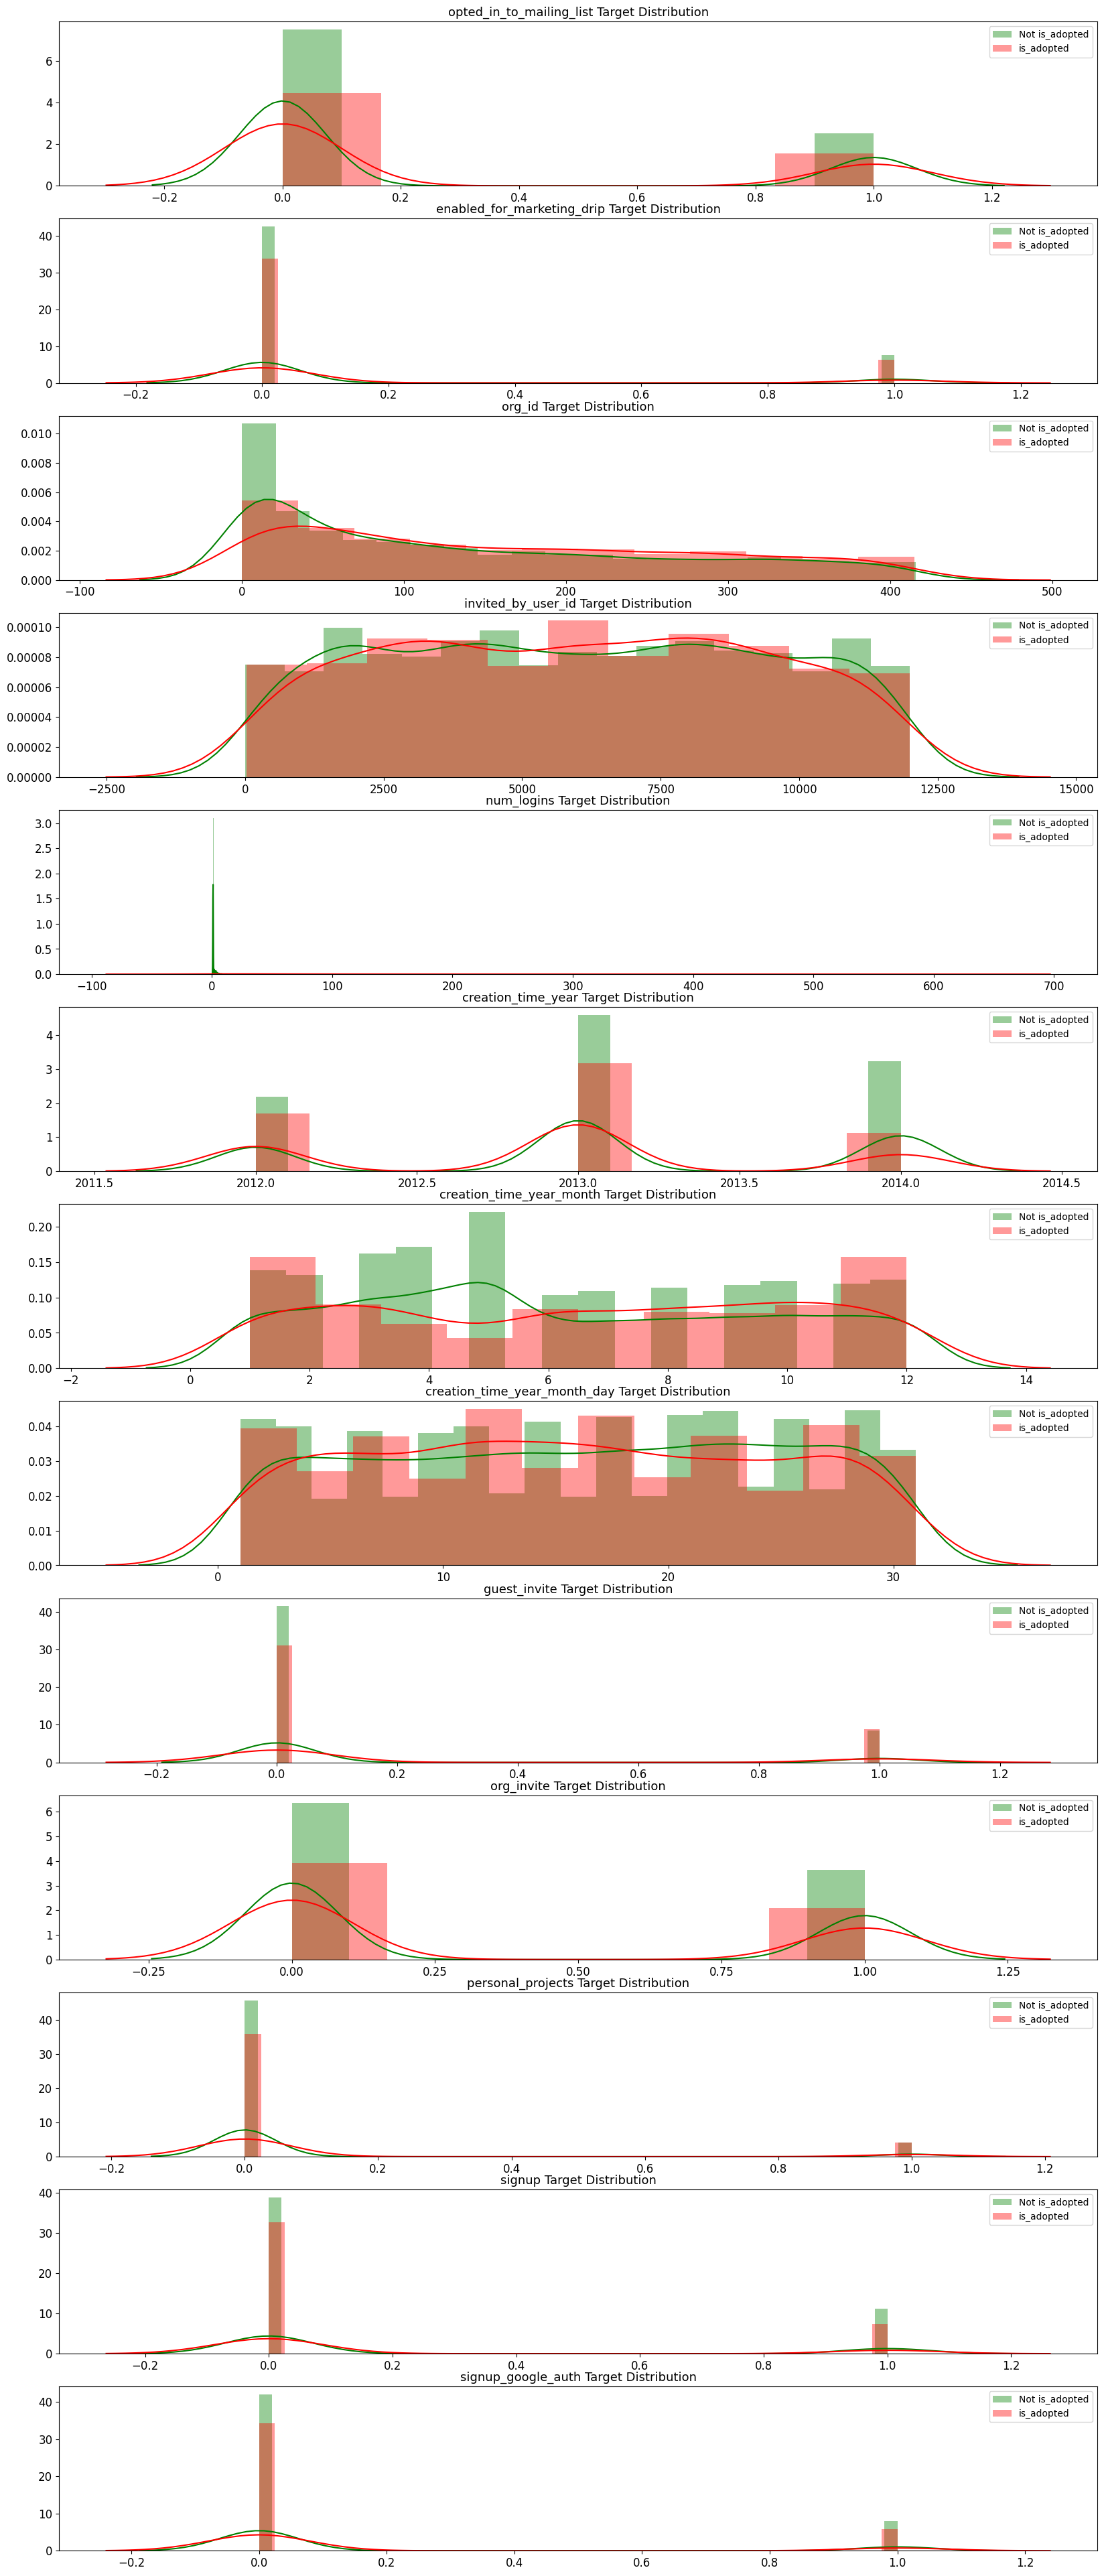

In [360]:
feature_columns = all_user_data.drop(['is_adopted'], axis=1).columns

from typing import List

def plot_variable_dists_by_class(df, target_column: str, features: List[str]):
    has_target: pd.Series = df[target_column] == 1

    fig, axes = plt.subplots(ncols=1, nrows=len(features), figsize=(20, 50), dpi=100)

    for i, feature in enumerate(features):
        sns.distplot(df.loc[~has_target][feature], label=f'Not {target_column}', ax=axes[i], color='green')
        sns.distplot(df.loc[has_target][feature], label=f'{target_column}', ax=axes[i], color='red')

        axes[i].set_xlabel('')
        axes[i].tick_params(axis='x', labelsize=12)
        axes[i].tick_params(axis='y', labelsize=12)
        axes[i].legend()

        axes[i].set_title(f'{feature} Target Distribution', fontsize=13)
    plt.show()


plot_variable_dists_by_class(all_user_data, 'is_adopted', feature_columns)

In [361]:
# Number of logins is highly correlated. Guest invites and personal projects are good predictors
all_user_data.corr()['is_adopted'].sort_values() * 100

creation_time_year              -10.700350
signup                           -3.813187
creation_time_year_month_day     -2.271394
signup_google_auth               -1.649695
org_invite                       -1.500735
invited_by_user_id               -0.148934
enabled_for_marketing_drip        0.455872
opted_in_to_mailing_list          0.764676
personal_projects                 2.927871
creation_time_year_month          4.735209
guest_invite                      5.370750
org_id                            7.810385
num_logins                       62.493558
is_adopted                      100.000000
Name: is_adopted, dtype: float64

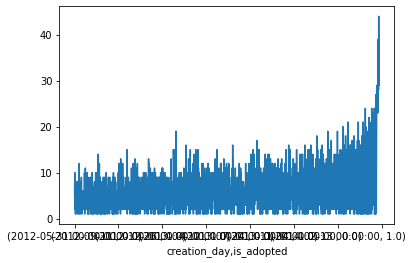

In [368]:
all_user_data['creation_day'] = creation_day
all_user_data['count'] = 1
all_user_data.groupby(['creation_day', 'is_adopted']).count()['count']